# Identify when a record begins based on data availability.

## Code!

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

%matplotlib inline

### Collect file paths.

In [2]:
obslens_tseries_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/'

#### Collect GISTEMP 5x5 file paths.

In [3]:
gistemp_5x5_files = glob.glob('%s/GISTEMP_5x5/20240820/xagg/ensembleChunk_5x5_????.nc' % obslens_tseries_dir)
gistemp_5x5_files.sort()

#### Collect HadCRUT5 file paths.

In [4]:
hadcrut5_files = glob.glob('%s/HadCRUT5/20240820/xagg/HadCRUT.5.0.2.0.analysis.anomalies.*.nc' % obslens_tseries_dir)
hadcrut5_files = [i for i in hadcrut5_files if "Trends" not in i]
hadcrut5_files.sort()

#### Collect DCENT unfilled file paths.

In [5]:
dcent_unfilled_files = glob.glob('%s/DCENT/20240901/xagg/DCENT_ensemble_1850_2023_member_???.nc' % obslens_tseries_dir)
dcent_unfilled_files = [i for i in dcent_unfilled_files if "Trends" not in i]
dcent_unfilled_files.sort()

## Identify a start year based on data availability

In [6]:
# test_gistemp = xr.open_dataset(gistemp_5x5_files[0]).sel(time=slice(None, "2020"))
# test_hadcrut = xr.open_dataset(hadcrut5_files[0]).sel(time=slice(None, "2020"))

Less conservative annual averaging.  
To quote Lenssen et al. (2019) "To have coverage for a year it must have coverage for at least three seasons, which requires at least 2 months in the season.”

In [7]:
def annual_data(
    ds: xr.DataArray,
    season_threshold: int=3,
    intraseason_threshold: int=2,
):
    """
    Mask data if any season is missing more than one month.
    To quote Lenssen et al. (2019) "To have coverage for a year it must have coverage for at least 
    three seasons, which requires at least 2 months in the season.”

    Args:
        ds (xr.DataArray): Input data

    Returns:
        ds (xr.DataArray): Mask of availability!
    """
    availability = ds["time.season"].where(~np.isnan(ds))
    
    complete_seasons = 0
    seasons = ["DJF", "MAM", "JJA", "SON"]
    for _szn in seasons:
        complete_seasons += ((availability == _szn).sum(dim="time") >= intraseason_threshold)
        
    return complete_seasons >= season_threshold

The simplest approach excludes too much data!

In [8]:
def startyear1(
    data_annual: xr.DataArray,
):
    """_summary_

    Args:
        data_annual (xr.DataArray): Actual data in an annual mean resolution. Remember use skipna=False!

    Returns:
        startyear_full: xarray DataArray with the start year for each region.
    """
    # Compute the last nan year and step one year forward.
    startyear = data_annual["year"].where(np.isnan(data_annual)).max(dim="year") + 1

    complete_tseries = ~np.isnan(data_annual).any(dim="year") # Identify regions without any nans
    absent_tseries = (startyear == data_annual.year[-1]) | (startyear == data_annual.year[-1] + 1) # Identify regions with all nans

    # Set the complete years to the record start year
    startyear_full = xr.where(complete_tseries, data_annual.year[0], startyear)
    # Set the years with consistent missing data to no start year
    startyear_full = xr.where(absent_tseries, np.nan, startyear_full)
    
    return startyear_full

This approach looks for availability for windows of various lengths beginning in the start year. It seems to work best because data gaps become less important as the record becomes longer.

In [9]:
def startyear_running_availability(
    mask_annual: xr.DataArray,
    windows: list = [5, 10, 20, 40],
    fraction: float = 0.6666,
    fillvalue: int = 2100,
):
    """
    This function identifies start years from a Boolean mask indicating 
    annual data availability input using two conditions:
        1. The data is present during the startyear.
        2. There is at least "fraction" data availability for windows of length "windows".

    Args:
        data_annual (xr.DataArray): Boolean mask in an annual mean resolution. i.e. Produced by annual_mask()
        windows (list, optional): Window lengths to test.
        fraction (float, optional): Fraction of data availability needed for a window to be considered available.
        fillvalue (int, optional): Real values to fill when a startdate is not detected. Defaults to 2100.

    Returns:
        startyear: xarray DataArray with the start year for each region.
    """

    # Center = False labels at the end of the window when I want the start. i.e. 1920 means the 1911-1920 mean
    # True if year represents the beginning of a window with coverage >= fraction.
    cumulative_avail_mask = mask_annual
    for _length in windows:
        _avail_mask = (mask_annual.rolling(
                dim={"year": _length},
                center=False,
            ).sum() >= _length * fraction
        ).shift(year=1 - _length, fill_value=True) # Shift so labelled by start and fill nans when incomplete
        cumulative_avail_mask = cumulative_avail_mask & _avail_mask

    startyear = mask_annual["year"].where(cumulative_avail_mask).min(dim="year")
    startyear = startyear.where(cumulative_avail_mask.any(dim="year"), fillvalue) # Fill nans if no available gaps

    return startyear

In [10]:
def multidim_groupby_map(
    data,
    groupby_dims,
    ffunc,
    **ffunc_kwargs,
):
    '''
    Hilarious recursive solution for the xarray groupby multiple dimensions problem. 
    xarray groupby objects cannot be grouped again, but you can map a function that does group them again.
    The base case is that we are grouping by a single dimension, which xarray can handle.
    Otherwise we groupby a new dimension and call our function on the remaining dimensions.
    
    Pass data as an xarray.DataArray, groupby_dims as a list, ffunc as the final function to apply,
    and ffunc_kwargs as arguments for ffunc.
    '''
    if len(groupby_dims)==1:
        return data.groupby(groupby_dims[0]).map(ffunc,**ffunc_kwargs) # using groupby_dims.pop() instead of groupby_dims[0] didn't work for some reason
    return data.groupby(groupby_dims.pop()).map(multidim_groupby_map,groupby_dims=groupby_dims,ffunc=ffunc,**ffunc_kwargs)


def annual_average_from_seasonal_averages(
    data: xr.DataArray,
):
    """Produce annual averages that weight seasons equally even if individual months are missing. 

    Args:
        data (xr.DataArray): Data with a time dimension that can be grouped using
        time.year and time.season.

    Returns:
        annual_avg (xr.DataArray): Averaged data
    """
    
    annual_avg = multidim_groupby_map(
        data,
        groupby_dims=["time.year", "time.season"],
        ffunc=xr.DataArray.mean,
        skipna=True,
        dim=["time"],
    ).mean(dim="season")
    
    return annual_avg


def reindex_time_by_startyear(
    data_ann_avg: xr.DataArray,
    startyears: xr.DataArray,
    stack_vars: list = None,
    spatial_str: str = "z"
):
    """Reindex the temporal dimension so records begin according to a supplied array of start years.

    Args:
        data_ann_avg (xr.DataArray): Annually averaged data with a "year" time dimension.
        startyears (xr.DataArray): Array of start years for the spatial dimensions of the data.
        stack_vars (list, optional): If the spatial dimensions are more than 1, pass them here.. Defaults to None.
        spatial_str (str, optional): Variable to assigned stacked spatial fields. Defaults to "z".

    Returns:
        xr.DataArray: Appropriately reindexed data with new time dimension "recordlength".
    """
    
    # This doesn't work yet but it should eventually.
    if stack_vars is not None:
        data_stacked = data_ann_avg.stack({spatial_str: stack_vars})
        startyears_stacked = startyears.stack({spatial_str: stack_vars})
    else:
        data_stacked = data_ann_avg
        startyears_stacked = startyears

    combino_list = []
    for _spatial_startyear in startyears_stacked:
        time_subset = data_ann_avg.sel(
            {spatial_str: _spatial_startyear[spatial_str],
             "year": slice(_spatial_startyear, None),
             },
        )
        
        durations = np.arange(1, time_subset.year.shape[0] + 1)
        
        time_subset = time_subset.rename({"year":"recordlength"}).assign_coords(recordlength=durations)
        combino_list.append(time_subset)
        # break
    # tseries_indexed_by_duration = xr.concat(combino_list, dim="RegionIndex") # Concat is smart and fills in nans
    tseries_indexed_by_duration = xr.combine_nested(
        combino_list,
        concat_dim=["RegionIndex"],
    )
    if stack_vars is not None:
        tseries_indexed_by_duration = tseries_indexed_by_duration.unstack()
    
    return tseries_indexed_by_duration

In [11]:
# gistemp_tas_var = "tas"
# hadcrut5_tas_var = "tas"
# _gistemp_ds = xr.open_dataset(gistemp_5x5_files[0])[gistemp_tas_var]
# _hadcrut5_ds = xr.open_dataset(hadcrut5_files[0])[hadcrut5_tas_var]

# # Create mask of available by Nathan's GISTEMP standard but 4 seasons.
# # Require 4 seasons because trends may be influenced by missing seasons.
# _availability_mask_gistemp = _gistemp_ds.groupby("time.year").map(annual_data, season_threshold=4)
# _availability_mask_hadcrut5 = _hadcrut5_ds.groupby("time.year").map(annual_data, season_threshold=4)

In [12]:
# # teststartyear_gistemp = startyear_gaplength(_availability_mask_gistemp)
# # teststartyear_hadcrut5 = startyear_gaplength(_availability_mask_hadcrut5)

# teststartyear_gistemp = startyear_running_availability(_availability_mask_hadcrut5)
# teststartyear_hadcrut5 = startyear_running_availability(_availability_mask_hadcrut5)

## Compute internally consistent start dates for each data product.

Compute the startdate for each ensemble member and take the latest one.

In [13]:
gistemp_tas_var = 'tas'
hadcrut5_tas_var = 'tas'
dcent_unfilled_tas_var = "temperature"

#### GISTEMP

It is weird the GISTEMP has availability in Antarctica and confidence in it...but actually it agrees pretty well with HadCRUT5.

E. Antarctica: 1960 (1957)  
W. Antarctica: 1984 (never)  
Arctic Ocean: 1931 (1933)  

In [14]:
earliest_startyear = 1900
fillvalue = 2100
gistemp_startyear_list = []
gistemp_availability_list = []
for i, _file in enumerate(gistemp_5x5_files):
    print(i, end=" ")
    _gistemp_ds = xr.open_dataset(_file)[gistemp_tas_var]
    
    # Create mask of available by Nathan's GISTEMP standard but 4 seasons.
    # Require 4 seasons because trends may be influenced by missing seasons.
    _availability_mask = _gistemp_ds.groupby("time.year").map(annual_data, season_threshold=4)
    _realization_startyears = startyear_running_availability(
        _availability_mask,
        fillvalue=fillvalue, # Mask nans into reals so that the quantile operation works later.
    )

    gistemp_startyear_list.append(_realization_startyears)
    gistemp_availability_list.append(_availability_mask)

del _gistemp_ds
gistemp_startyears = xr.concat(gistemp_startyear_list, dim="realization")
gistemp_availability = xr.concat(gistemp_availability_list, dim="realization")
gistemp_startyear_mid = gistemp_startyears.quantile(0.5, dim="realization")
# Set values less than 1900 to 1900.
gistemp_startyear_final = xr.where(
    gistemp_startyear_mid > earliest_startyear,
    gistemp_startyear_mid, 
    earliest_startyear,
)
gistemp_startyear_final = gistemp_startyear_final.where(gistemp_startyear_final != fillvalue) # Revert masking to a nan
del gistemp_startyear_mid, gistemp_startyear_list, gistemp_availability_list

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [26]:
# Now iterate over the files and re-index them!

gistemp_reindexed_list = []
for i, _file in enumerate(gistemp_5x5_files):
    print(i, end=" ")
    _gistemp_ds = xr.open_dataset(_file)[gistemp_tas_var]
    _mask = gistemp_availability.sel(realization=_gistemp_ds.realization)
    
    _gistemp_ann_avg = annual_average_from_seasonal_averages(_gistemp_ds).where(_mask)

    _gistemp_reindex = reindex_time_by_startyear(
        data_ann_avg=_gistemp_ann_avg,
        startyears=gistemp_startyear_final,
        spatial_str="RegionIndex",
    )
    gistemp_reindexed_list.append(_gistemp_reindex)
    # if i == 2: break
gistemp_reindexed = xr.concat(gistemp_reindexed_list, dim="realization")
del _gistemp_ds, gistemp_reindexed_list

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [28]:
gistemp_reindexed.to_netcdf(f"{obslens_tseries_dir}/GISTEMP_5x5/20240820/xagg/ensembleChunks_0001_0200.reindexed.IPCCRegions.190001-202012.nc")

In [ ]:
# Inputs:
# - determined startyears for each region or lat-lon gridcell
# - data with the format of year and region or lat-lon

# Outputs:
# - Reshaped array where the data is selected starting at the startyear for each location

#### HadCRUT5

In [38]:
earliest_startyear = 1900
fillvalue = 2100
hadcrut5_startyear_list = []
hadcrut5_availability_list = []
for i, _file in enumerate(hadcrut5_files):
    print(i, end=" ")
    _hadcrut5_ds = xr.open_dataset(_file)[hadcrut5_tas_var]
    
    # Create mask of available by Nathan's GISTEMP standard but 4 seasons.
    # Require 4 seasons because trends may be influenced by missing seasons.
    _availability_mask = _hadcrut5_ds.groupby("time.year").map(annual_data, season_threshold=4)
    _realization_startyears = startyear_running_availability(
        _availability_mask,
        fillvalue=fillvalue, # Mask nans into reals so that the quantile operation works later.
    )

    hadcrut5_startyear_list.append(_realization_startyears)
    hadcrut5_availability_list.append(_availability_mask)

del _hadcrut5_ds
hadcrut5_startyears = xr.concat(hadcrut5_startyear_list, dim="realization")
hadcrut5_availability = xr.concat(hadcrut5_availability_list, dim="realization")
hadcrut5_startyear_mid = hadcrut5_startyears.quantile(0.5, dim="realization")
# Set values less than 1900 to 1900.
hadcrut5_startyear_final = xr.where(
    hadcrut5_startyear_mid > earliest_startyear,
    hadcrut5_startyear_mid, 
    earliest_startyear,
)
hadcrut5_startyear_final = hadcrut5_startyear_final.where(hadcrut5_startyear_final != fillvalue) # Revert masking to a nan
del hadcrut5_startyear_mid, hadcrut5_startyear_list, hadcrut5_availability_list

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

The only real difference in the start years is for the S. Pacific Ocean region (1900 for GISTEMP, 1964 for HadCRUT5). Otherwise the agreement is pretty good. Some disagreement in E. and W. Antarctica but that isn't surprising.

In [41]:
gistemp_startyear_final.sel(RegionIndex=slice(44, 49))

<xarray.DataArray 'year' (RegionIndex: 6)> Size: 48B
array([  nan, 1984., 1930., 1900., 1900., 1900.])
Coordinates:
  * RegionIndex   (RegionIndex) int64 48B 44 45 46 47 48 49
    Continent     (RegionIndex) <U15 360B 'POLAR' 'POLAR' ... 'PACIFIC'
    Type          (RegionIndex) <U10 240B 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 600B 'E.Antarctica' ... 'S.Pacific-Ocean'
    RegionAbbrev  (RegionIndex) <U4 96B 'EAN' 'WAN' 'ARO' 'NPO' 'EPO' 'SPO'
    quantile      float64 8B 0.5

In [40]:
hadcrut5_startyear_final.sel(RegionIndex=slice(44, 49))

<xarray.DataArray 'year' (RegionIndex: 6)> Size: 48B
array([1957.,   nan, 1933., 1908., 1923., 1964.])
Coordinates:
  * RegionIndex   (RegionIndex) int64 48B 44 45 46 47 48 49
    Continent     (RegionIndex) <U15 360B 'POLAR' 'POLAR' ... 'PACIFIC'
    Type          (RegionIndex) <U10 240B 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 600B 'E.Antarctica' ... 'S.Pacific-Ocean'
    RegionAbbrev  (RegionIndex) <U4 96B 'EAN' 'WAN' 'ARO' 'NPO' 'EPO' 'SPO'
    quantile      float64 8B 0.5

In [39]:
# Now iterate over the files and re-index them!

hadcrut5_reindexed_list = []
for i, _file in enumerate(hadcrut5_files):
    print(i, end=" ")
    _hadcrut5_ds = xr.open_dataset(_file)[hadcrut5_tas_var]
    _mask = hadcrut5_availability.sel(realization=_hadcrut5_ds.realization)
    
    _hadcrut5_ann_avg = annual_average_from_seasonal_averages(_hadcrut5_ds).where(_mask)

    _hadcrut5_reindex = reindex_time_by_startyear(
        data_ann_avg=_hadcrut5_ann_avg,
        startyears=hadcrut5_startyear_final,
        spatial_str="RegionIndex",
    )
    hadcrut5_reindexed_list.append(_hadcrut5_reindex)
    # if i == 2: break
hadcrut5_reindexed = xr.concat(hadcrut5_reindexed_list, dim="realization")
hadcrut5_reindexed = hadcrut5_reindexed.sortby("realization")

del _hadcrut5_ds, hadcrut5_reindexed_list

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [52]:
# Save
hadcrut5_reindexed.to_netcdf(f"{obslens_tseries_dir}/HadCRUT5/20240820/xagg/HadCRUT.5.0.2.0.001_200.reindexed.IPCCRegions.190001-202412.nc")

#### DCENT

In [60]:
earliest_startyear = 1900
fillvalue = 2100
dcent_unfilled_startyear_list = []
dcent_unfilled_availability_list = []
for i, _file in enumerate(dcent_unfilled_files):
    print(i, end=" ")
    _dcent_ds = xr.open_dataset(_file)[dcent_unfilled_tas_var]
    
    # Create mask of available by Nathan's GISTEMP standard but 4 seasons.
    # Require 4 seasons because trends may be influenced by missing seasons.
    _availability_mask = _dcent_ds.groupby("time.year").map(annual_data, season_threshold=4)
    _realization_startyears = startyear_running_availability(
        _availability_mask,
        fillvalue=fillvalue, # Mask nans into reals so that the quantile operation works later.
    )

    dcent_unfilled_startyear_list.append(_realization_startyears)
    dcent_unfilled_availability_list.append(_availability_mask)

del _dcent_ds
dcent_unfilled_startyears = xr.concat(dcent_unfilled_startyear_list, dim="realization")
dcent_unfilled_availability = xr.concat(dcent_unfilled_availability_list, dim="realization")
dcent_unfilled_startyear_mid = dcent_unfilled_startyears.quantile(0.5, dim="realization")
# Set values less than 1900 to 1900.
dcent_unfilled_startyear_final = xr.where(
    dcent_unfilled_startyear_mid > earliest_startyear,
    dcent_unfilled_startyear_mid, 
    earliest_startyear,
)
dcent_unfilled_startyear_final = dcent_unfilled_startyear_final.where(dcent_unfilled_startyear_final != fillvalue) # Revert masking to a nan
del dcent_unfilled_startyear_mid, dcent_unfilled_startyear_list, dcent_unfilled_availability_list

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [61]:
dcent_unfilled_startyear_final

<xarray.DataArray 'year' (RegionIndex: 58)> Size: 464B
array([  nan, 2005.,   nan, 1900., 1900., 1900., 1907., 1908., 1906.,
       1961.,   nan, 1952., 2005., 1957., 1959., 1978., 1954., 1900.,
       1928., 1903.,   nan, 1933.,   nan,   nan,   nan,   nan, 1926.,
       1952.,   nan, 1936., 1938., 1960., 1949., 1956., 1961., 1924.,
       1981., 1902., 1953., 1959., 1941., 1900., 1964., 1957.,   nan,
         nan,   nan, 1951., 1961., 2005., 1906., 1949., 1977., 1909.,
       1905., 1950., 1958.,   nan])
Coordinates:
  * RegionIndex   (RegionIndex) int64 464B 0 1 2 3 4 5 6 ... 52 53 54 55 56 57
    Continent     (RegionIndex) <U15 3kB 'POLAR' 'NORTH-AMERICA' ... 'SOUTHERN'
    Type          (RegionIndex) <U10 2kB 'Land' 'Land' ... 'Ocean' 'Ocean'
    RegionName    (RegionIndex) <U25 6kB 'Greenland/Iceland' ... 'Southern-Oc...
    RegionAbbrev  (RegionIndex) <U4 928B 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'
    quantile      float64 8B 0.5

In [62]:
# Now iterate over the files and re-index them!

dcent_unfilled_reindexed_list = []
for i, _file in enumerate(dcent_unfilled_files):
    print(i, end=" ")
    _dcent_ds = xr.open_dataset(_file)[dcent_unfilled_tas_var]
    _mask = dcent_unfilled_availability.sel(realization=_dcent_ds.realization)
    
    _dcent_unfilled_ann_avg = annual_average_from_seasonal_averages(_dcent_ds).where(_mask)

    _dcent_unfilled_reindex = reindex_time_by_startyear(
        data_ann_avg=_dcent_unfilled_ann_avg,
        startyears=dcent_unfilled_startyear_final,
        spatial_str="RegionIndex",
    )
    dcent_unfilled_reindexed_list.append(_dcent_unfilled_reindex)
    # if i == 2: break
dcent_unfilled_reindexed = xr.concat(dcent_unfilled_reindexed_list, dim="realization")
dcent_unfilled_reindexed = dcent_unfilled_reindexed.sortby("realization")

del _dcent_ds, dcent_unfilled_reindexed_list

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [72]:
# Save
dcent_unfilled_reindexed.to_netcdf(f"{obslens_tseries_dir}/DCENT/20240901/xagg/DCENT_ensemble_1850_2023.001_200.reindexed.IPCCRegions.190001-202312.nc")

Disagreement between

Text(0, 0.5, 'SST Anomaly (deg. C)')

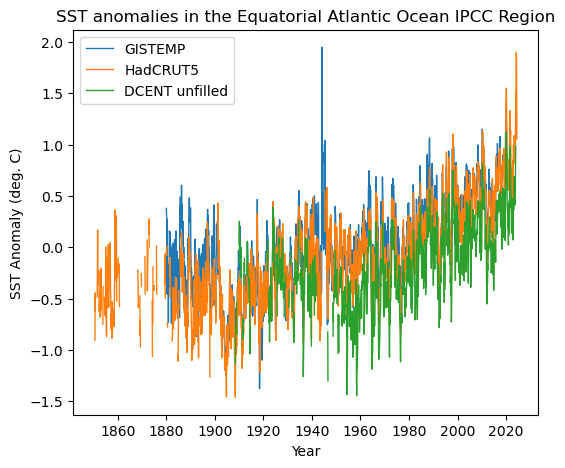

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.plot(
    _gistemp_ds["time"],
    _gistemp_ds.sel(RegionIndex=51).squeeze(),
    label="GISTEMP",
    linewidth=1,
)
ax.plot(
    _hadcrut5_ds["time"],
    _hadcrut5_ds.sel(RegionIndex=51).squeeze(),
    label="HadCRUT5",
    linewidth=1,
)
ax.plot(
    _dcent_ds["time"],
    _dcent_ds.sel(RegionIndex=51).squeeze(),
    label="DCENT unfilled",
    linewidth=1,
)

plt.legend()

plt.title("SST anomalies in the Equatorial Atlantic Ocean IPCC Region")

ax.set_xlabel("Year")
ax.set_ylabel("SST Anomaly (deg. C)")

### Process time series into unforced trends as a function of trend duration

Using code from:  

trend_uncertainty/PIC_trend_preproc.ipynb

__Define functions:__

In [6]:
def get_trends_allstartyears(data,duration,startyears,dim='year'):
    '''
    Calculate: 
    a. trends of a given duration
    '''
    
    description = 'Trends for an unforced Pre-Industrial Control simulation sampled by timeseries startyear and duration.'
    
    # Initialize list to save to
    trends_list = []
    
    for i,startyear in enumerate(startyears):
        
        _startyr = startyear
        _endyr   = startyear + duration - 1

        _tsel = data.sel(year=slice(_startyr,_endyr)) # index differently here because the dates are different

        # Calculate the slope
        # print(_tsel)
        # print(dim)
        _tsel_polyfit = _tsel.polyfit(dim=dim, deg=1, skipna=False)['polyfit_coefficients'].sel(degree=1)
        _tsel_slopes  = _tsel_polyfit.drop('degree')
        
        trends_list.append(_tsel_slopes.assign_coords({'startyear':startyear}).expand_dims('startyear'))
        
    out = xr.concat(trends_list,dim='startyear').assign_coords({'duration':duration}).expand_dims('duration')
        
    return out

In [7]:
def compute_trends_wrapper(data,durations=np.arange(5,81,),**kwargs):
    '''
    Wrapper for running 'get_allvar_allstartyears' for different durations.
    Setup with correct startyears and concatenate at the end.
    '''
    
    first_year = data['year'][0]
    last_year  = data['year'][-1]

    trends_allstartyear_allduration_list = []

    for duration in durations:
        print(duration,end=' ')
        _startyears = np.arange(first_year,last_year+2-duration,1)

        allvar_onedur_ds = get_trends_allstartyears(data,
                                                    duration=duration,
                                                    startyears=_startyears,
                                                    **kwargs
                                                   )
        
        trends_allstartyear_allduration_list.append(allvar_onedur_ds)
                
    trends_allstartyear_allduration_ds = xr.concat(trends_allstartyear_allduration_list,dim='duration')
        
    # Add metadata
    trends_allstartyear_allduration_ds = trends_allstartyear_allduration_ds.assign_coords({"RegionName":   ("RegionIndex", data.RegionName)})
    trends_allstartyear_allduration_ds = trends_allstartyear_allduration_ds.assign_coords({"RegionAbbrev": ("RegionIndex", data.RegionAbbrev)})

    trends_allstartyear_allduration_ds.name = 'TAS_trends'
    
    return trends_allstartyear_allduration_ds

### Compute trends for all durations and save

In [8]:
gistemp_tas_var = 'tas'
hadcrut5_tas_var = 'tas'

#### GISTEMP 5x5

In [9]:
test_ds1 = xr.open_dataset(gistemp_5x5_files[0])
test_ds2 = xr.open_dataset(gistemp_5x5_files[1])

In [10]:
test_ds1 = xr.open_dataset(hadcrut5_files[0])
test_ds2 = xr.open_dataset(hadcrut5_files[1])

In [11]:
test_ds2

<xarray.Dataset>
Dimensions:       (RegionIndex: 58, realization: 1, time: 1476)
Coordinates:
  * realization   (realization) int64 1
  * time          (time) datetime64[ns] 1900-01-16T12:00:00 ... 2022-12-16T12...
  * RegionIndex   (RegionIndex) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
    RegionAbbrev  (RegionIndex) object ...
    RegionName    (RegionIndex) object ...
Data variables:
    tas           (realization, time, RegionIndex) float64 ...

In [12]:
test_ds1

<xarray.Dataset>
Dimensions:      (duration: 119, latitude: 36, longitude: 72, realization: 1)
Coordinates:
    startyear    int64 ...
  * longitude    (longitude) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * latitude     (latitude) float64 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * duration     (duration) int64 3 4 5 6 7 8 9 ... 115 116 117 118 119 120 121
  * realization  (realization) int64 1
Data variables:
    tas          (duration, latitude, longitude, realization) float64 ...

In [13]:
gistemp_5x5_ds = xr.open_mfdataset(gistemp_5x5_files,chunks={'RegionIndex':1})

In [14]:
%%time
gistemp_filelist = []
for _file in gistemp_5x5_files:
    _gistemp_ds = xr.open_dataset(_file)
    _gistemp_annual = _gistemp_ds[gistemp_tas_var].groupby('time.year').mean('time')

    gistemp_filelist.append(_gistemp_annual)

gistemp_annual = xr.concat(gistemp_filelist, dim="realization")

CPU times: user 12.9 s, sys: 239 ms, total: 13.1 s
Wall time: 13.9 s


In [15]:
%%time

gistemp_trends_all = compute_trends_wrapper(gistemp_annual,durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 1min 4s, sys: 3.33 s, total: 1min 7s
Wall time: 1min 13s


In [17]:
gistemp_trends_all.to_netcdf('%s/%s/ensembleChunks_0001_0200.trends.190001-202012.nc' % (obslens_tseries_dir,'GISTEMP_5x5/20240820/'))

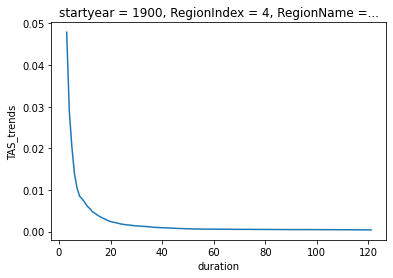

In [18]:
gistemp_trends_all.sel(RegionIndex=4, startyear=1900).sortby("realization").std("realization").plot()

In [19]:
del gistemp_5x5_ds,gistemp_annual,gistemp_trends_all

#### HadCRUT5

In [24]:
%%time
hadcrut5_filelist = []
for _file in hadcrut5_files:
    # print(_file)
    _hadcrut5_ds = xr.open_dataset(_file)
    _hadcrut5_annual = _hadcrut5_ds[hadcrut5_tas_var].groupby('time.year').mean('time')

    hadcrut5_filelist.append(_hadcrut5_annual)

hadcrut5_annual = xr.concat(hadcrut5_filelist, dim="realization")

/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/

CPU times: user 13.6 s, sys: 181 ms, total: 13.8 s
Wall time: 20.7 s


In [28]:
%%time

hadcrut5_trends_all = compute_trends_wrapper(hadcrut5_annual,durations=np.arange(3,122,1))

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 CPU times: user 1min 7s, sys: 1.09 s, total: 1min 8s
Wall time: 1min 13s


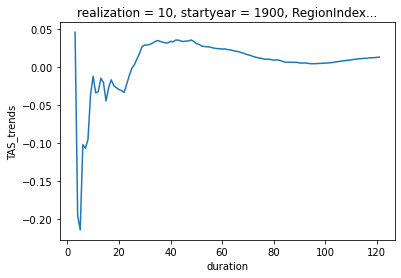

In [29]:
hadcrut5_trends_all.sel(startyear=1900,RegionIndex=0, realization=10).plot()

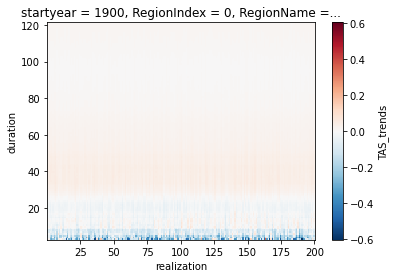

In [30]:
hadcrut5_trends_all.sel(startyear=1900,RegionIndex=0,).sortby("realization").plot()

#### Interesting behavior in the observational uncertainty curve in Central North America when starting the record at 1900.

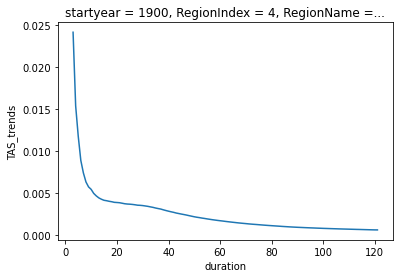

In [31]:
hadcrut5_trends_all.sel(RegionIndex=4, startyear=1900).sortby("realization").std("realization").plot()

In [32]:
hadcrut5_trends_all.to_netcdf('%s/%s/HadCRUT.5.0.2.0_1_200.trends.190001-202212.nc' % (obslens_tseries_dir,'HadCRUT5/20240820/'))

In [33]:
del hadcrut5_annual,hadcrut5_trends_all